In [1]:
import sys
import os
from pathlib import Path
import warnings
from contextlib import redirect_stdout, redirect_stderr
import io

# Suppress sklearn version warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', message='.*InconsistentVersionWarning.*')
warnings.filterwarnings('ignore', message='.*unpickle estimator.*')

# Suppress PyTorch Lightning seed messages
import logging
logging.getLogger('pytorch_lightning').setLevel(logging.WARNING)

# Add project root to path
PROJECT_ROOT = Path('/mnt/home/mlee1/vdm_BIND')
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import h5py

# Import BIND and utilities
from bind.bind import BIND
from bind.workflow_utils import ConfigLoader, load_normalization_stats

# Setup publication-quality plotting
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.figsize': (12, 8),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Output directory for figures
FIGURE_DIR = PROJECT_ROOT / 'analysis' / 'figures' / 'bind'
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {FIGURE_DIR}")

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/6qvrglgqdpwhbw9zv2nh07fpd7a4wq31-py-torchvision-0.15.2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Figures will be saved to: /mnt/home/mlee1/vdm_BIND/analysis/figures/bind


In [2]:
import sys
sys.path.insert(0, '/mnt/home/mlee1/vdm_BIND')

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from bind.bind import BIND
from bind.workflow_utils import ConfigLoader
from bind.power_spec import compute_power_spectrum_simple
from analysis.paper_utils import setup_plotting_style

setup_plotting_style()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


## 1. Define Models to Compare

In [4]:
MODELS = {
    'VDM': '/mnt/home/mlee1/vdm_BIND/configs/clean_vdm_regularized.ini',
    # 'Triple VDM': '/mnt/home/mlee1/vdm_BIND/configs/clean_vdm_triple.ini',
    # 'DDPM': '/mnt/home/mlee1/vdm_BIND/configs/ddpm.ini',
    # 'DSM': '/mnt/home/mlee1/vdm_BIND/configs/dsm.ini',
    # 'Interpolant': '/mnt/home/mlee1/vdm_BIND/configs/interpolant.ini',
    'OT Flow': '/mnt/home/mlee1/vdm_BIND/configs/ot_flow.ini',
    'Consistency': '/mnt/home/mlee1/vdm_BIND/configs/consistency.ini',
    'Stochastic Interpolant': '/mnt/home/mlee1/vdm_BIND/configs/stochastic_interpolant.ini',
}

SAMPLING_STEPS = {
    'VDM': 250,
    'Triple VDM': 250,
    'DDPM': 250,
    'DSM': 100,
    'Interpolant': 50,
    'Stochastic Interpolant': 50,
    'OT Flow': 50,
    'Consistency': 5,
}

CHANNEL_NAMES = ['Hydro DM', 'Gas', 'Stars']

## 2. Setup Simulation

In [5]:
SIM_NUM = 0
SNAPNUM = 90

CAMELS_ROOT = Path('/mnt/ceph/users/camels/Sims')
DMO_PATH = CAMELS_ROOT / 'IllustrisTNG_DM' / 'L50n512' / 'CV' / f'CV_{SIM_NUM}'
HYDRO_PATH = CAMELS_ROOT / 'IllustrisTNG' / 'L50n512' / 'CV' / f'CV_{SIM_NUM}'

BOX_SIZE = 50000.0  # kpc/h
GRID_SIZE = 1024  # Must be 1024 to get 128x128 cutouts for 6.25 Mpc regions

print(f"DMO: {DMO_PATH}")
print(f"Hydro: {HYDRO_PATH}")

DMO: /mnt/ceph/users/camels/Sims/IllustrisTNG_DM/L50n512/CV/CV_0
Hydro: /mnt/ceph/users/camels/Sims/IllustrisTNG/L50n512/CV/CV_0


## 3. Run BIND for Each Model

In [6]:
# Load conditional parameters (fiducial cosmology)
import pandas as pd
metadata = pd.read_csv('/mnt/home/mlee1/Sims/IllustrisTNG_extras/L50n512/SB35/SB35_param_minmax.csv')
base_params = list(metadata['FiducialVal'])

N_REALIZATIONS = 10  # Number of realizations for stochastic models

results = {}

for name, config_path in MODELS.items():
    if not Path(config_path).exists():
        print(f"Skipping {name}: config not found")
        continue
    
    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        config = ConfigLoader(config_path, verbose=False)
    if config.best_ckpt is None:
        print(f"Skipping {name}: no checkpoint")
        continue
    
    try:
        print(f"Running {name}...", end=" ", flush=True)
        
        # Initialize BIND pipeline with stdout suppressed
        with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
            bind = BIND(
                simulation_path=str(DMO_PATH),
                snapnum=SNAPNUM,
                boxsize=BOX_SIZE,
                gridsize=GRID_SIZE,
                config_path=config_path,
                dim='2d',
                axis=2,
                verbose=False,
            )
        
        # Step 1: Voxelize simulation
        bind.voxelize_simulation()
        
        # Store DMO field
        dmo_field = bind.sim_grid.copy() if hasattr(bind, 'sim_grid') else None
        
        # Step 2: Extract halos with large-scale conditioning
        bind.extract_halos(0.3, use_large_scale=True, num_large_scales=3)
        
        # Reshape conditional parameters to match number of halos
        num_halos = len(bind.extracted['metadata'])
        conditional_params = np.reshape(base_params * num_halos, (num_halos, -1))
        
        # Step 3: Generate halos with N_REALIZATIONS samples
        bind.generate_halos(batch_size=N_REALIZATIONS, conditional_params=conditional_params, conserve_mass=True)
        
        # Step 4: Paste halos for all realizations
        final_maps = bind.paste_halos(realizations=N_REALIZATIONS)
        
        # Store all realizations
        results[name] = {
            'all_realizations': np.stack(final_maps),  # (N_REALIZATIONS, H, W)
            'mean': np.mean(final_maps, axis=0),       # Mean over realizations
            'std': np.std(final_maps, axis=0),         # Std for uncertainty
            'dmo': dmo_field
        }
        print(f"Done ({num_halos} halos, {N_REALIZATIONS} realizations)")
        del bind
        torch.cuda.empty_cache()
        
    except Exception as e:
        import traceback
        print(f"Failed: {e}")
        traceback.print_exc()

Running VDM... 

Seed set to 8


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
⚙️  ParamEmbedding: Conditional mode (n_params=35)
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZING CLEAN VDM MODEL

📊 MODEL CONFIGURATION:
  Image shape: (3, 128, 128)
  Noise schedule: learned_nn
  Gamma range: [-13.3, 13.0]
  Data noise (per-channel): (0.001, 0.001, 0.001)
  Loss weights (diffusion, latent, recons): 1.0, 1.0, 1.0

🎯 CHANNEL WEIGHTS: (1, 1, 1)

✓ Parameter prediction enabled (weight=0.01)




Generating Samples (250 steps):   0%|          | 0/45 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples (250 steps): 100%|██████████| 45/45 [05:04<00:00,  6.76s/it]


torch.Size([45, 10, 3, 128, 128])
Done (45 halos, 10 realizations)
Running OT Flow... 

Seed set to 8


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
⚙️  ParamEmbedding: Conditional mode (n_params=35)
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZED OT FLOW MATCHING MODEL
  Learning rate: 0.0001
  Sampling steps: 50
  OT method: exact
  Stochastic: False (sigma=0.0)
  x0 mode: dm_copy
  Use OT training: True
  POT available: True



Generating Samples (50 steps):   0%|          | 0/45 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples (50 steps): 100%|██████████| 45/45 [01:00<00:00,  1.34s/it]


torch.Size([45, 10, 3, 128, 128])
Done (45 halos, 10 realizations)
Running Consistency... 

Seed set to 8


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
⚙️  ParamEmbedding: Conditional mode (n_params=35)
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZED LIGHT CONSISTENCY MODEL
  Learning rate: 5e-05
  Sampling steps: 1
  CT discretization steps: 18
  x0 mode: zeros
  Param conditioning: True
  Denoising pretraining: True (10 epochs)
  EMA decay: 0.9999



Generating Samples (1 steps):   0%|          | 0/45 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples (1 steps): 100%|██████████| 45/45 [00:01<00:00, 35.77it/s]


torch.Size([45, 10, 3, 128, 128])
Done (45 halos, 10 realizations)
Running Stochastic Interpolant... 

Seed set to 8


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
⚙️  ParamEmbedding: Conditional mode (n_params=35)
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZED LIGHT INTERPOLANT MODEL
  Learning rate: 0.0001
  Sampling steps: 50
  Stochastic: True (sigma=0.1)
  x0 mode: dm_copy
  Param conditioning: True



Generating Samples (50 steps):   0%|          | 0/45 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples (50 steps): 100%|██████████| 45/45 [01:00<00:00,  1.35s/it]


torch.Size([45, 10, 3, 128, 128])
Done (45 halos, 10 realizations)


In [7]:
# Check if realizations are actually different
for name, data in results.items():
    all_real = data['all_realizations']
    print(f"\n{name}:")
    print(f"  Shape: {all_real.shape}")
    print(f"  Max difference between realizations: {np.max(all_real) - np.min(all_real):.6f}")
    print(f"  Std across realizations (per pixel): {np.std(all_real, axis=0).mean():.6f}")
    
    # Check if all realizations are identical
    if np.allclose(all_real[0], all_real[1]):
        print(f"  ⚠️  Realizations 0 and 1 are IDENTICAL!")
        print(f"      This means the model is using deterministic sampling.")
        print(f"      For stochastic models, set x0_mode='noise' or use SDE sampling.")
    else:
        print(f"  ✓ Realizations are different")
        print(f"  Max pixel-wise difference: {np.abs(all_real[0] - all_real[1]).max():.6f}")


VDM:
  Shape: (10, 1024, 1024)
  Max difference between realizations: 4118779527168.000000
  Std across realizations (per pixel): 1983815040.000000
  ✓ Realizations are different
  Max pixel-wise difference: 1958704971776.000000

OT Flow:
  Shape: (10, 1024, 1024)
  Max difference between realizations: 3462565986304.000000
  Std across realizations (per pixel): 561.952515
  ⚠️  Realizations 0 and 1 are IDENTICAL!
      This means the model is using deterministic sampling.
      For stochastic models, set x0_mode='noise' or use SDE sampling.

Consistency:
  Shape: (10, 1024, 1024)
  Max difference between realizations: 3346889179136.000000
  Std across realizations (per pixel): 2034380160.000000
  ✓ Realizations are different
  Max pixel-wise difference: 978045370368.000000

Stochastic Interpolant:
  Shape: (10, 1024, 1024)
  Max difference between realizations: 3443551633408.000000
  Std across realizations (per pixel): 2464793088.000000
  ✓ Realizations are different
  Max pixel-wise

## 4. Load Ground Truth

In [8]:
from vdm.io_utils import load_simulation, project_particles_2d

# CAMELS hydro sims use snapdir_XXX format
hydro_snapdir = str(HYDRO_PATH / f'snapdir_{SNAPNUM:03d}')
print(f"Loading from: {hydro_snapdir}")

_, _, hydro_dm_pos, hydro_dm_mass, gas_pos, gas_mass, star_pos, star_mass = load_simulation(
    str(DMO_PATH), hydro_snapdir, snapnum=SNAPNUM
)

print(f"Hydro DM: {hydro_dm_pos.shape}, Gas: {gas_pos.shape}, Stars: {star_pos.shape}")

# Project each component and sum for total matter field
dm_field = project_particles_2d(hydro_dm_pos, hydro_dm_mass, BOX_SIZE/1000, GRID_SIZE, axis=2)
gas_field = project_particles_2d(gas_pos, gas_mass, BOX_SIZE/1000, GRID_SIZE, axis=2)
star_field = project_particles_2d(star_pos, star_mass, BOX_SIZE/1000, GRID_SIZE, axis=2)

gt_total = dm_field + gas_field + star_field
print(f"Ground truth total loaded: {gt_total.shape}")

Loading from: /mnt/ceph/users/camels/Sims/IllustrisTNG/L50n512/CV/CV_0/snapdir_090
Hydro DM: (134217728, 3), Gas: (127990117, 3), Stars: (4733834, 3)
Ground truth total loaded: (1024, 1024)


## 5. Compute Power Spectra

In [9]:
box_mpc = BOX_SIZE / 1000

# Ground truth total power spectrum
gt_pk, gt_k = compute_power_spectrum_simple(gt_total, BoxSize=box_mpc)

# DMO power spectrum (from first model's dmo_field - they should all be the same)
dmo_field = list(results.values())[0]['dmo']
dmo_pk, dmo_k = compute_power_spectrum_simple(dmo_field, BoxSize=box_mpc)

# Interpolate DMO to common k values
dmo_pk_interp = np.interp(gt_k, dmo_k, dmo_pk)

# Ground truth transfer function
gt_transfer = gt_pk / dmo_pk_interp

# Model transfer functions - compute T = P/P_DMO for EACH realization, then take mean/std
model_transfer = {}
for name, data in results.items():
    # Compute transfer function for each realization
    T_all = []
    for realization in data['all_realizations']:
        pk_r, k_r = compute_power_spectrum_simple(realization, BoxSize=box_mpc)
        pk_r_interp = np.interp(gt_k, k_r, pk_r)
        T_r = pk_r_interp / dmo_pk_interp
        T_all.append(T_r)
    T_all = np.array(T_all)
    
    model_transfer[name] = {
        'k': gt_k,
        'T_mean': np.mean(T_all, axis=0),
        'T_std': np.std(T_all, axis=0),
        'T_min': np.min(T_all, axis=0),
        'T_max': np.max(T_all, axis=0),
        'T_all': T_all,
    }
    
    # Check if there's actual variance (for debugging)
    max_spread = np.max(T_all) - np.min(T_all)
    print(f"{name}: T spread = {max_spread:.4f}")

print(f"\nComputed transfer functions for {len(model_transfer)} models ({N_REALIZATIONS} realizations each)")


Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.02 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds

Computing power spectrum of t

## 6. Power Spectrum Comparison

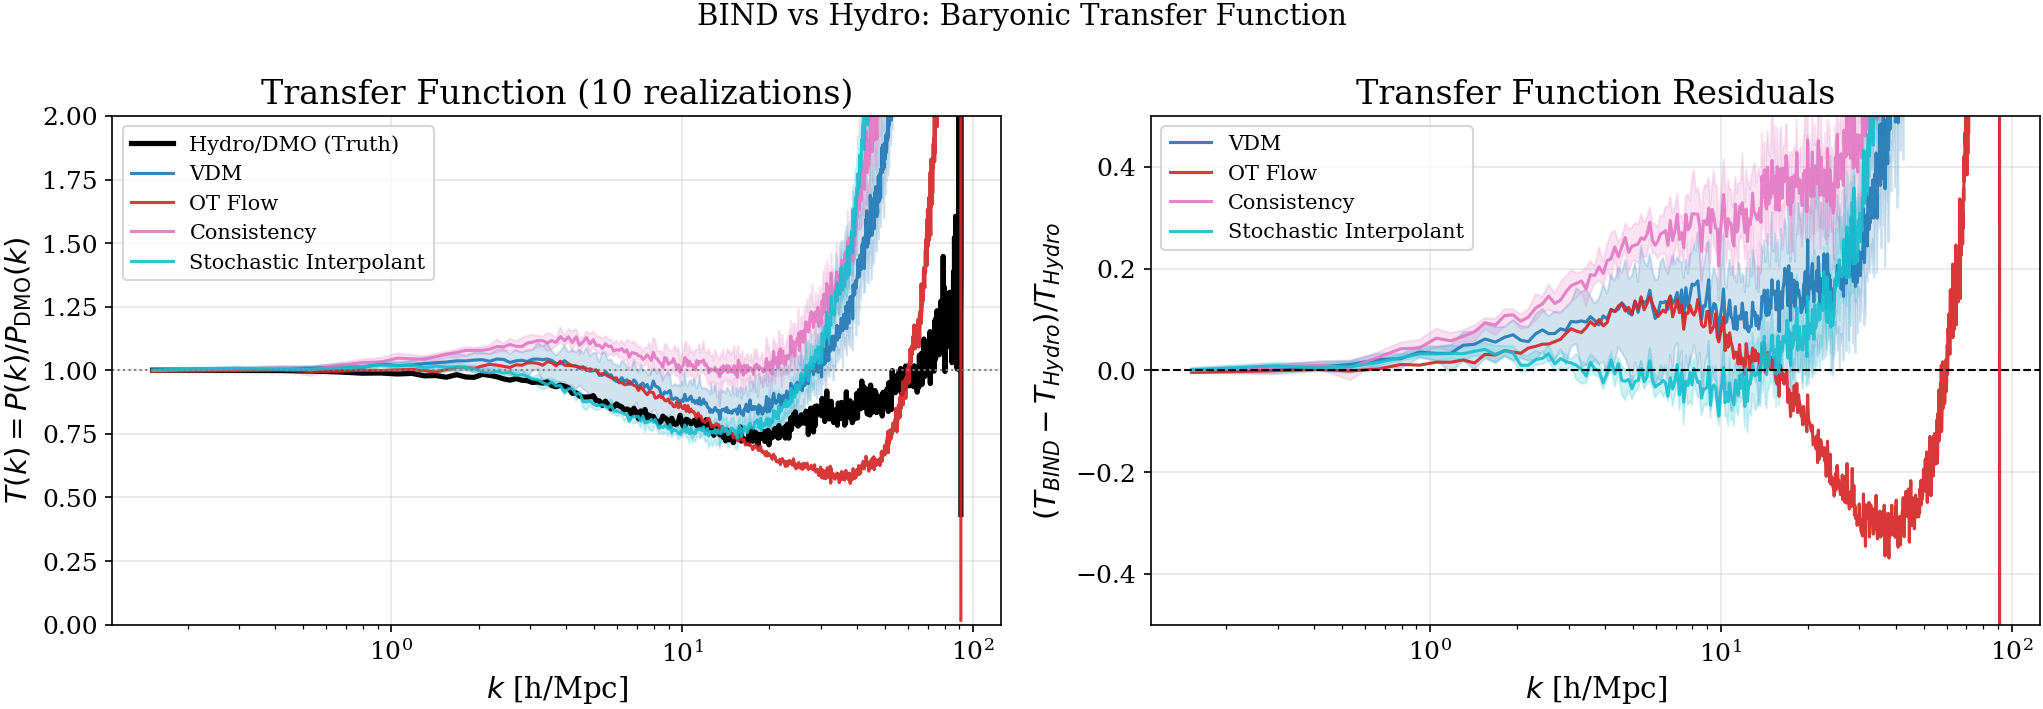

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

# Left: Transfer functions T = P/P_DMO with spread
ax = axes[0]
ax.semilogx(gt_k, gt_transfer, 'k-', lw=2.5, label='Hydro/DMO (Truth)')

for j, (name, T_data) in enumerate(model_transfer.items()):
    # Mean transfer function
    ax.semilogx(gt_k, T_data['T_mean'], color=colors[j], lw=1.5, label=f'{name}', alpha=0.9)
    
    # Spread from all realizations (min to max)
    ax.fill_between(gt_k, T_data['T_min'], T_data['T_max'], color=colors[j], alpha=0.2)

ax.axhline(1, color='gray', ls=':', lw=1)
ax.set_xlabel(r'$k$ [h/Mpc]')
ax.set_ylabel(r'$T(k) = P(k) / P_{\rm DMO}(k)$')
ax.set_title(f'Transfer Function ({N_REALIZATIONS} realizations)')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.set_ylim(0, 2)

# Right: Residuals (T_model - T_hydro) / T_hydro with spread
ax = axes[1]

for j, (name, T_data) in enumerate(model_transfer.items()):
    # Mean residual
    residual_mean = (T_data['T_mean'] - gt_transfer) / gt_transfer
    ax.semilogx(gt_k, residual_mean, color=colors[j], lw=1.5, label=name, alpha=0.9)
    
    # Spread
    residual_min = (T_data['T_min'] - gt_transfer) / gt_transfer
    residual_max = (T_data['T_max'] - gt_transfer) / gt_transfer
    ax.fill_between(gt_k, residual_min, residual_max, color=colors[j], alpha=0.2)

ax.axhline(0, color='k', ls='--', lw=1)
ax.set_xlabel(r'$k$ [h/Mpc]')
ax.set_ylabel(r'$(T_{BIND} - T_{Hydro}) / T_{Hydro}$')
ax.set_title('Transfer Function Residuals')
ax.set_ylim(-0.5, 0.5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.suptitle('BIND vs Hydro: Baryonic Transfer Function', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Residuals

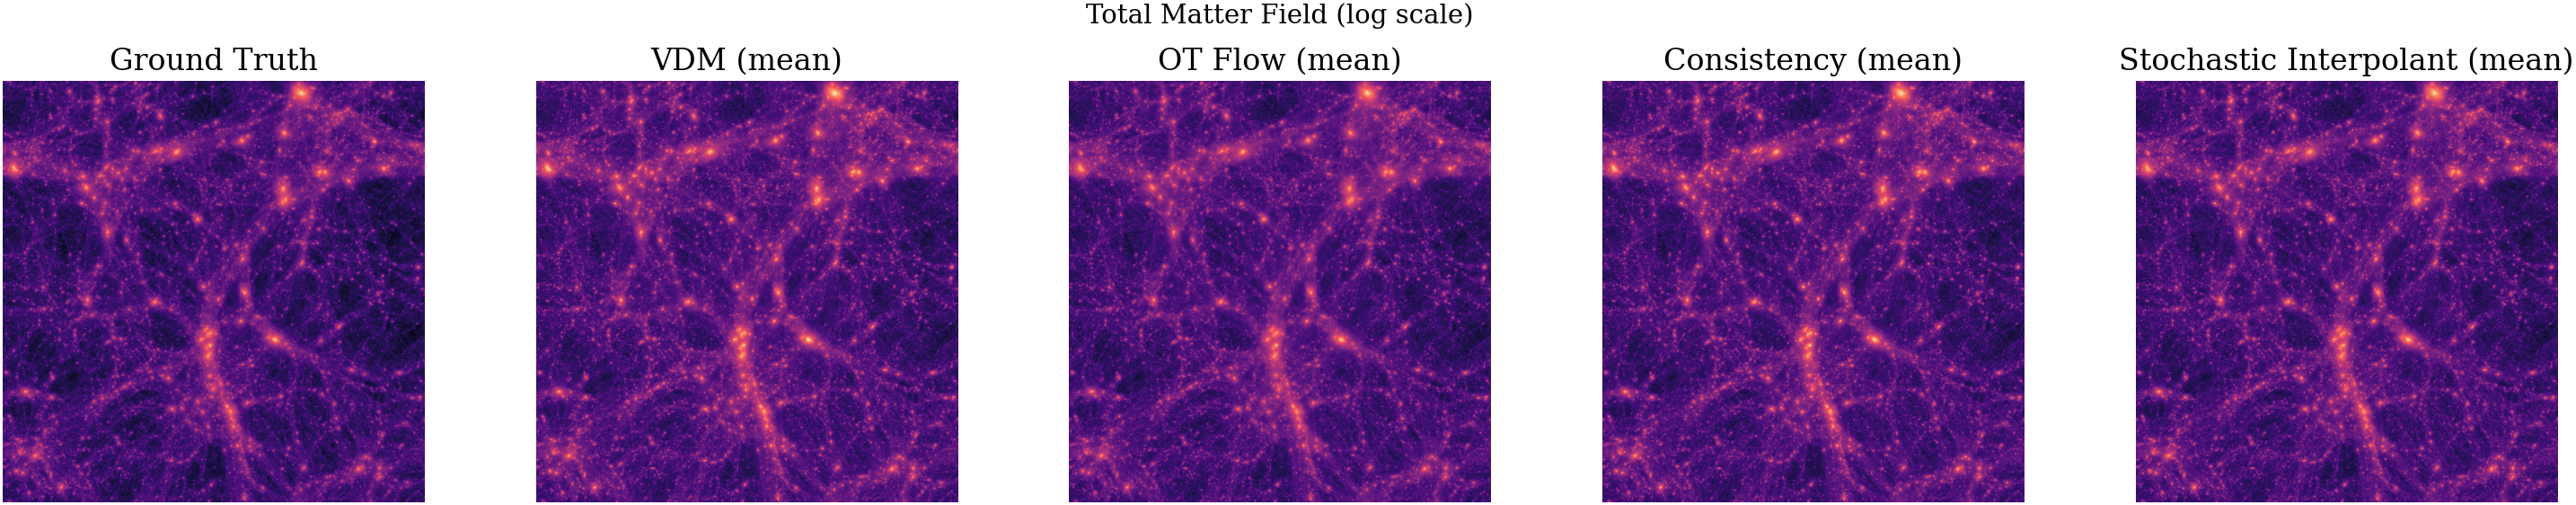

In [11]:
# Visual comparison of total matter fields (using mean)
n_models = len(results)
if n_models > 0:
    fig, axes = plt.subplots(1, n_models + 1, figsize=(4*(n_models+1), 4))
    
    axes[0].imshow(np.log10(gt_total + 1), cmap='magma')
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')
    
    for col, (name, data) in enumerate(results.items(), 1):
        axes[col].imshow(np.log10(data['mean'] + 1), cmap='magma')
        axes[col].set_title(f'{name} (mean)')
        axes[col].axis('off')
    
    plt.suptitle('Total Matter Field (log scale)', fontsize=14)
    plt.tight_layout()
    plt.show()

## 8. Visual Comparison

In [52]:
# Summary statistics (using mean transfer function)
rows = []
for name, data in results.items():
    pred_mean = data['mean']
    T_data = model_transfer[name]
    
    # Correlation with mean field
    corr = np.corrcoef(pred_mean.flatten(), gt_total.flatten())[0, 1]
    
    # Transfer function ratio at k=1 h/Mpc
    idx_k1 = np.argmin(np.abs(gt_k - 1.0))
    T_model_k1 = T_data['T_mean'][idx_k1]
    T_gt_k1 = gt_transfer[idx_k1]
    transfer_ratio = T_model_k1 / T_gt_k1
    
    # Mean fractional error in transfer function
    frac_err = np.mean(np.abs(T_data['T_mean'] - gt_transfer) / gt_transfer)
    
    # Spread in T at k=1 (std across realizations)
    T_std_k1 = T_data['T_std'][idx_k1]
    
    rows.append({
        'Model': name, 
        'Correlation': f"{corr:.4f}", 
        'T_ratio (k=1)': f"{transfer_ratio:.3f}", 
        'Mean |ΔT/T|': f"{frac_err:.3f}",
        'T_std (k=1)': f"{T_std_k1:.4f}"
    })

df = pd.DataFrame(rows)
print(df.to_string(index=False))

                 Model Correlation T_ratio (k=1) Mean |ΔT/T| T_std (k=1)
           Consistency      0.9407         1.077       3.302      0.0075
Stochastic Interpolant      0.9624         0.962       0.227      0.0000


## 9. Summary Table

In [ ]:
import pandas as pd

rows = []
for name, data in results.items():
    pred = data['predicted']
    for i, (ch, key) in enumerate(zip(CHANNEL_NAMES, ['dm', 'gas', 'stars'])):
        gt = gt_fields[key]
        p = pred[i] if pred.ndim == 3 else pred
        
        corr = np.corrcoef(p.flatten(), gt.flatten())[0, 1]
        gt_k, gt_p = gt_pk[ch]['k'], gt_pk[ch]['pk']
        model_p = np.interp(gt_k, model_pk[name][ch]['k'], model_pk[name][ch]['pk'])
        pk_ratio = model_p[np.argmin(np.abs(gt_k - 1.0))] / gt_p[np.argmin(np.abs(gt_k - 1.0))]
        
        rows.append({'Model': name, 'Channel': ch, 'Correlation': corr, 'Pk Ratio (k=1)': pk_ratio})

df = pd.DataFrame(rows)
print("Correlation:")
print(df.pivot(index='Model', columns='Channel', values='Correlation').round(4))
print("\nPk Ratio at k=1 h/Mpc:")
print(df.pivot(index='Model', columns='Channel', values='Pk Ratio (k=1)').round(3))

## 10. Halo Mass Comparison: Generated vs Hydro

Compare the total mass in generated halos with the corresponding hydro cutouts at the same locations.

In [12]:
# Re-run BIND to get halo extraction metadata (positions, cutout info)
# We need the extracted halo metadata to know where to take cutouts from hydro

# Pick one model to get the halo locations (all models use the same halos)
model_name = list(MODELS.keys())[0]
config_path = MODELS[model_name]

with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    config = ConfigLoader(config_path, verbose=False)
    
    bind = BIND(
        simulation_path=str(DMO_PATH),
        snapnum=SNAPNUM,
        boxsize=BOX_SIZE,
        gridsize=GRID_SIZE,
        config_path=config_path,
        dim='2d',
        axis=2,
        verbose=False,
    )

# Voxelize and extract halos
bind.voxelize_simulation()
bind.extract_halos(0.3, use_large_scale=True, num_large_scales=3)

# Get halo metadata
halo_metadata = bind.extracted['metadata']
print(f"Extracted {len(halo_metadata)} halos")
print(f"Sample halo: position = {halo_metadata[0]['position']}, mass = {halo_metadata[0]['mass']:.2e} M_sun/h")

Extracted 45 halos
Sample halo: position = [ 1555.8647 35365.305  17983.736 ], mass = 2.65e+04 M_sun/h


In [13]:
def extract_cutout_2d(field, center_pos_kpc, cutout_size_mpc, boxsize_kpc, gridsize, axis=2):
    """
    Extract a 2D cutout from a projected field at a given position.
    
    Args:
        field: 2D projected field (gridsize x gridsize)
        center_pos_kpc: 3D position in kpc/h
        cutout_size_mpc: Size of cutout in Mpc/h
        boxsize_kpc: Box size in kpc/h
        gridsize: Grid resolution
        axis: Projection axis (0, 1, or 2)
        
    Returns:
        2D cutout array
    """
    boxsize_mpc = boxsize_kpc / 1000.0
    center_pos_mpc = center_pos_kpc / 1000.0
    
    # Get 2D coordinates (excluding projection axis)
    axes = [0, 1, 2]
    proj_axes = axes[:axis] + axes[axis+1:]
    center_2d = center_pos_mpc[proj_axes]
    
    # Calculate pixel coordinates
    pix_size = boxsize_mpc / gridsize
    half_cutout_pix = int(cutout_size_mpc / pix_size / 2)
    center_pix = (center_2d / pix_size).astype(int)
    
    # Extract with periodic boundary conditions
    cutout_size_pix = 2 * half_cutout_pix
    cutout = np.zeros((cutout_size_pix, cutout_size_pix))
    
    for i in range(cutout_size_pix):
        for j in range(cutout_size_pix):
            ix = (center_pix[0] - half_cutout_pix + i) % gridsize
            jx = (center_pix[1] - half_cutout_pix + j) % gridsize
            cutout[i, j] = field[ix, jx]
    
    return cutout

# Extract hydro cutouts at the same halo locations
# Use the 6.25 Mpc/h scale to match the generated cutouts
CUTOUT_SIZE_MPC = 6.25

# Ground truth fields from cell 11 (already loaded)
hydro_fields = {
    'dm': dm_field,
    'gas': gas_field,
    'stars': star_field,
    'total': gt_total
}

# Extract cutouts for each halo
hydro_cutouts = {key: [] for key in hydro_fields.keys()}

for halo in tqdm(halo_metadata, desc="Extracting hydro cutouts"):
    pos = halo['position']  # in kpc/h
    
    for key, field in hydro_fields.items():
        cutout = extract_cutout_2d(field, pos, CUTOUT_SIZE_MPC, BOX_SIZE, GRID_SIZE, axis=2)
        hydro_cutouts[key].append(cutout)

# Stack into arrays
for key in hydro_cutouts:
    hydro_cutouts[key] = np.stack(hydro_cutouts[key])
    
print(f"Extracted {len(halo_metadata)} hydro cutouts")
print(f"Cutout shape: {hydro_cutouts['total'].shape}")

Extracting hydro cutouts: 100%|██████████| 45/45 [00:02<00:00, 17.74it/s]

Extracted 45 hydro cutouts
Cutout shape: (45, 128, 128)


In [ ]:
# Now we need to get the generated halo cutouts for each model
# Re-run the generation but store the individual halo outputs

generated_cutouts = {}

for name, config_path in MODELS.items():
    if not Path(config_path).exists():
        continue
    
    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        config = ConfigLoader(config_path, verbose=False)
    if config.best_ckpt is None:
        print(f"Skipping {name}: no checkpoint")
        continue
    
    print(f"Generating {name}...", end=" ", flush=True)
    
    try:
        with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
            bind = BIND(
                simulation_path=str(DMO_PATH),
                snapnum=SNAPNUM,
                boxsize=BOX_SIZE,
                gridsize=GRID_SIZE,
                config_path=config_path,
                dim='2d',
                axis=2,
                verbose=False,
            )
        
        bind.voxelize_simulation()
        bind.extract_halos(0.3, use_large_scale=True, num_large_scales=3)
        
        num_halos = len(bind.extracted['metadata'])
        conditional_params = np.reshape(base_params * num_halos, (num_halos, -1))
        
        # Generate halos - this stores individual outputs in bind.generated_images
        bind.generate_halos(batch_size=1, conditional_params=conditional_params, conserve_mass=True)
        
        # Get the generated cutouts (before pasting)
        # bind.generated_images is a list of arrays, one per halo
        # Each element has shape (N_realizations, C, H, W) or (N_realizations, H, W)
        gen_outputs_list = bind.generated_images
        
        # Convert list to array and take first realization
        # Stack along halo dimension
        if isinstance(gen_outputs_list, list):
            # Each element is (N_realizations, C, H, W) or (N_realizations, H, W)
            # Take first realization from each halo
            gen_outputs = np.stack([g[0] for g in gen_outputs_list])  # (N_halos, C, H, W) or (N_halos, H, W)
        else:
            gen_outputs = gen_outputs_list
            if gen_outputs.ndim == 5:
                # Shape: (N_halos, N_realizations, C, H, W) -> take first realization
                gen_outputs = gen_outputs[:, 0, :, :, :]
        
        generated_cutouts[name] = {
            'outputs': gen_outputs.copy(),  # (N_halos, C, H, W) or (N_halos, H, W)
            'shape': gen_outputs.shape
        }
        
        print(f"Done - shape: {gen_outputs.shape}")
        
        del bind
        torch.cuda.empty_cache()
        
    except Exception as e:
        import traceback
        print(f"Failed: {e}")
        traceback.print_exc()

print(f"\nGenerated cutouts for {len(generated_cutouts)} models")

Generating VDM... 

In [21]:
# Compare total mass in generated vs hydro cutouts
# Sum over all pixels in each cutout to get total mass

channel_names = ['Hydro DM', 'Gas', 'Stars']
hydro_keys = ['dm', 'gas', 'stars']

mass_comparison = {}

for name, data in generated_cutouts.items():
    gen_outputs = data['outputs']  # (N_halos, 3, H, W) or (N_halos, H, W)
    
    # Handle different output shapes
    if gen_outputs.ndim == 4:
        # 3-channel output: (N_halos, 3, H, W)
        n_halos, n_channels, H, W = gen_outputs.shape
    else:
        # Single channel output: (N_halos, H, W)
        n_halos, H, W = gen_outputs.shape
        n_channels = 1
    
    mass_comparison[name] = {'per_channel': {}, 'total': {}}
    
    # Per-channel comparison
    for ch_idx, (ch_name, hydro_key) in enumerate(zip(channel_names, hydro_keys)):
        if n_channels == 1 and ch_idx > 0:
            continue  # Skip if single channel output
            
        # Generated mass per halo
        if n_channels > 1:
            gen_mass = np.sum(gen_outputs[:, ch_idx, :, :], axis=(1, 2))  # (N_halos,)
        else:
            gen_mass = np.sum(gen_outputs, axis=(1, 2))  # (N_halos,)
        
        # Hydro mass per halo (need to resize hydro cutouts to match generated size)
        hydro_field = hydro_cutouts[hydro_key]  # (N_halos, cutout_H, cutout_W)
        
        # Resize hydro cutouts to match generated size if needed
        if hydro_field.shape[1] != H:
            hydro_resized = []
            for halo_idx in range(n_halos):
                hf = hydro_field[halo_idx]
                hf_tensor = torch.tensor(hf, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                hf_resized = F.interpolate(hf_tensor, size=(H, W), mode='bilinear', align_corners=False)
                # Scale to preserve total mass
                scale_factor = hf.sum() / hf_resized.sum().item() if hf_resized.sum().item() > 0 else 1.0
                hydro_resized.append(hf_resized.squeeze().numpy() * scale_factor)
            hydro_field_resized = np.stack(hydro_resized)
        else:
            hydro_field_resized = hydro_field
        
        hydro_mass = np.sum(hydro_field_resized, axis=(1, 2))  # (N_halos,)
        
        mass_comparison[name]['per_channel'][ch_name] = {
            'generated': gen_mass,
            'hydro': hydro_mass,
            'ratio': gen_mass / (hydro_mass + 1e-10),  # Avoid division by zero
        }
    
    # Total mass comparison (sum of all channels)
    if n_channels > 1:
        gen_total_mass = np.sum(gen_outputs, axis=(1, 2, 3))  # Sum over channels and spatial
    else:
        gen_total_mass = np.sum(gen_outputs, axis=(1, 2))
    
    hydro_total_mass = np.sum(hydro_cutouts['total'], axis=(1, 2))
    # Resize if needed
    if hydro_cutouts['total'].shape[1] != H:
        hydro_total_resized = []
        for halo_idx in range(n_halos):
            hf = hydro_cutouts['total'][halo_idx]
            hf_tensor = torch.tensor(hf, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            hf_resized = F.interpolate(hf_tensor, size=(H, W), mode='bilinear', align_corners=False)
            scale_factor = hf.sum() / hf_resized.sum().item() if hf_resized.sum().item() > 0 else 1.0
            hydro_total_resized.append(hf_resized.squeeze().numpy() * scale_factor)
        hydro_total_resized = np.stack(hydro_total_resized)
        hydro_total_mass = np.sum(hydro_total_resized, axis=(1, 2))
    
    mass_comparison[name]['total'] = {
        'generated': gen_total_mass,
        'hydro': hydro_total_mass,
        'ratio': gen_total_mass / (hydro_total_mass + 1e-10),
    }

print("Mass comparison computed for all models")

Mass comparison computed for all models


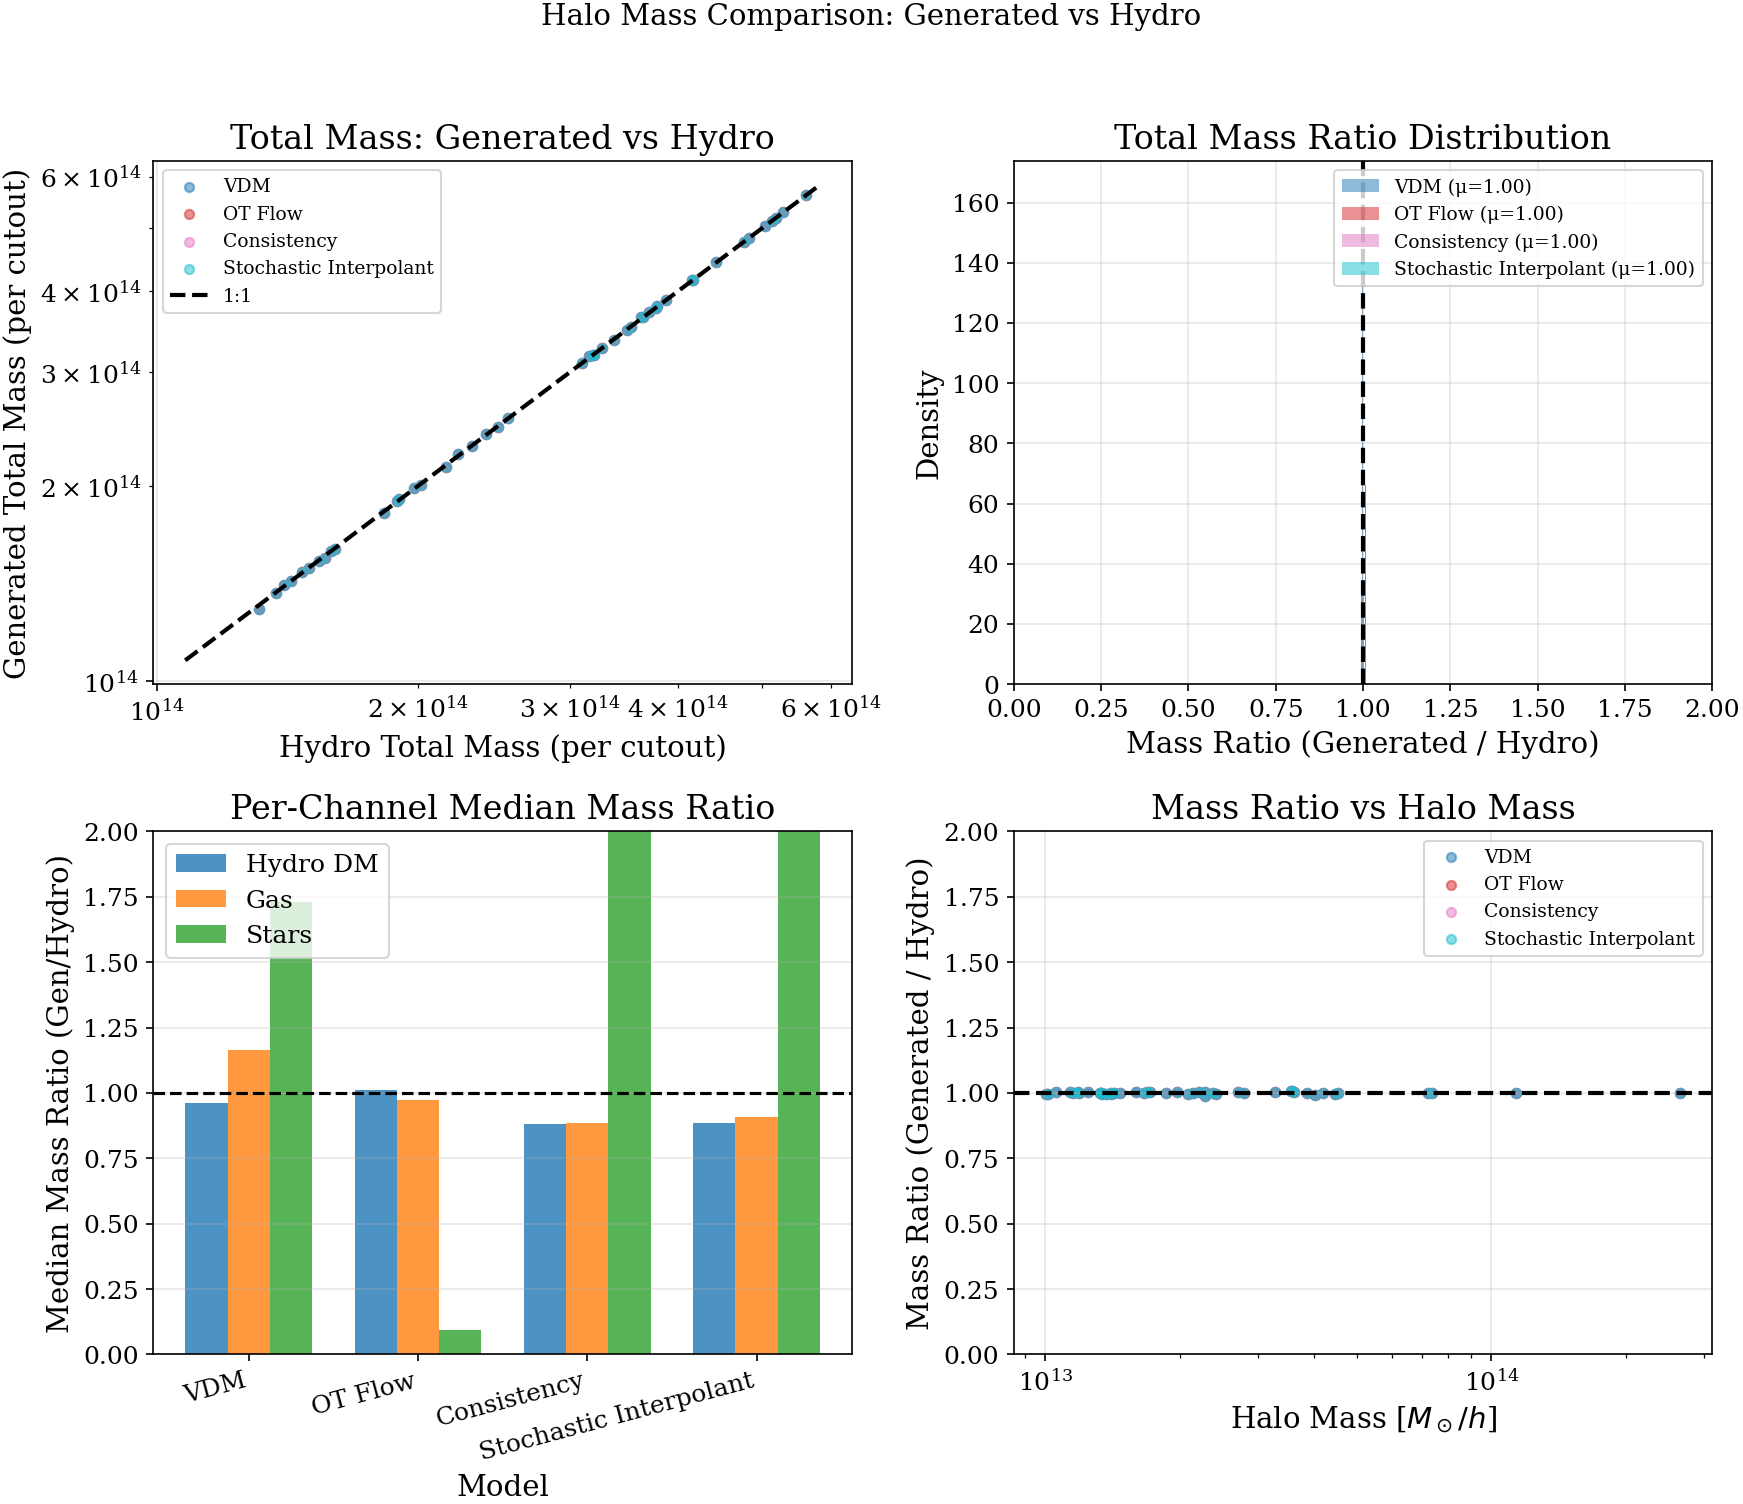

In [ ]:
# Plot mass comparison: Generated vs Hydro for each channel
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(mass_comparison)))

# Plot 1: Total mass scatter
ax = axes[0, 0]
for idx, (name, data) in enumerate(mass_comparison.items()):
    total_data = data['total']
    ax.scatter(total_data['hydro'], total_data['generated'], 
               alpha=0.5, s=20, label=name, color=colors[idx])

# Add 1:1 line
lims = [ax.get_xlim(), ax.get_ylim()]
lim_min = min(lims[0][0], lims[1][0])
lim_max = max(lims[0][1], lims[1][1])
ax.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', lw=2, label='1:1')
ax.set_xlabel('Hydro Total Mass (per cutout)')
ax.set_ylabel('Generated Total Mass (per cutout)')
ax.set_title('Total Mass: Generated vs Hydro')
ax.legend(fontsize=9)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Plot 2: Mass ratio histogram (total)
ax = axes[0, 1]
for idx, (name, data) in enumerate(mass_comparison.items()):
    ratios = data['total']['ratio']
    ax.hist(ratios, bins=30, alpha=0.5, label=f'{name} (μ={np.mean(ratios):.2f})', 
            color=colors[idx], density=True)

ax.axvline(1.0, color='k', ls='--', lw=2)
ax.set_xlabel('Mass Ratio (Generated / Hydro)')
ax.set_ylabel('Density')
ax.set_title('Total Mass Ratio Distribution')
ax.legend(fontsize=9)
ax.set_xlim(0, 2)
ax.grid(True, alpha=0.3)

# Plot 3: Per-channel mass scatter (Hydro vs Generated for each channel)
ax = axes[1, 0]
markers = ['o', 's', '^']  # Different markers for each channel
channel_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

for idx, (name, data) in enumerate(mass_comparison.items()):
    for ch_idx, ch_name in enumerate(channel_names):
        if ch_name in data['per_channel']:
            ch_data = data['per_channel'][ch_name]
            # Use different alpha/size for different models
            ax.scatter(ch_data['hydro'], ch_data['generated'], 
                      alpha=0.4, s=15, color=channel_colors[ch_idx], 
                      marker=markers[ch_idx],
                      label=f'{ch_name}' if idx == 0 else None)

# Add 1:1 line
lims = [ax.get_xlim(), ax.get_ylim()]
lim_min = min(lims[0][0], lims[1][0])
lim_max = max(lims[0][1], lims[1][1])
ax.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', lw=2)
ax.set_xlabel('Hydro Mass (per cutout)')
ax.set_ylabel('Generated Mass (per cutout)')
ax.set_title('Per-Channel Mass: Generated vs Hydro')
ax.legend(fontsize=9)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Plot 4: Mass ratio vs halo mass
ax = axes[1, 1]
halo_masses = np.array([h['mass'] for h in halo_metadata]) * 1e10  # Convert to M_sun/h

for idx, (name, data) in enumerate(mass_comparison.items()):
    ratios = data['total']['ratio']
    ax.scatter(halo_masses, ratios, alpha=0.5, s=20, label=name, color=colors[idx])

ax.axhline(1.0, color='k', ls='--', lw=2)
ax.set_xlabel(r'Halo Mass [$M_\odot/h$]')
ax.set_ylabel('Mass Ratio (Generated / Hydro)')
ax.set_title('Mass Ratio vs Halo Mass')
ax.legend(fontsize=9)
ax.set_xscale('log')
ax.set_ylim(0, 2)
ax.grid(True, alpha=0.3)

plt.suptitle('Halo Mass Comparison: Generated vs Hydro', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURE_DIR / 'halo_mass_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
# Summary table of mass statistics
rows = []
for name, data in mass_comparison.items():
    # Total mass stats
    total_ratios = data['total']['ratio']
    rows.append({
        'Model': name,
        'Channel': 'Total',
        'Mean Ratio': f"{np.mean(total_ratios):.3f}",
        'Median Ratio': f"{np.median(total_ratios):.3f}",
        'Std': f"{np.std(total_ratios):.3f}",
        '% within 20%': f"{100 * np.mean(np.abs(total_ratios - 1) < 0.2):.1f}%"
    })
    
    # Per-channel stats
    for ch_name in channel_names:
        if ch_name in data['per_channel']:
            ch_ratios = data['per_channel'][ch_name]['ratio']
            rows.append({
                'Model': name,
                'Channel': ch_name,
                'Mean Ratio': f"{np.mean(ch_ratios):.3f}",
                'Median Ratio': f"{np.median(ch_ratios):.3f}",
                'Std': f"{np.std(ch_ratios):.3f}",
                '% within 20%': f"{100 * np.mean(np.abs(ch_ratios - 1) < 0.2):.1f}%"
            })

df_mass = pd.DataFrame(rows)
print("Mass Ratio Statistics (Generated / Hydro):")
print(df_mass.to_string(index=False))

Mass Ratio Statistics (Generated / Hydro):
                 Model  Channel Mean Ratio Median Ratio   Std % within 20%
                   VDM    Total      1.000        1.000 0.004       100.0%
                   VDM Hydro DM      0.960        0.961 0.014       100.0%
                   VDM      Gas      1.167        1.163 0.034        86.7%
                   VDM    Stars      2.519        1.730 1.983        22.2%
               OT Flow    Total      1.000        1.000 0.004       100.0%
               OT Flow Hydro DM      1.010        1.010 0.004       100.0%
               OT Flow      Gas      0.971        0.971 0.017       100.0%
               OT Flow    Stars      0.296        0.095 0.446         6.7%
           Consistency    Total      1.000        1.000 0.004       100.0%
           Consistency Hydro DM      0.879        0.880 0.017       100.0%
           Consistency      Gas      0.884        0.886 0.029       100.0%
           Consistency    Stars     25.779       24.129 4

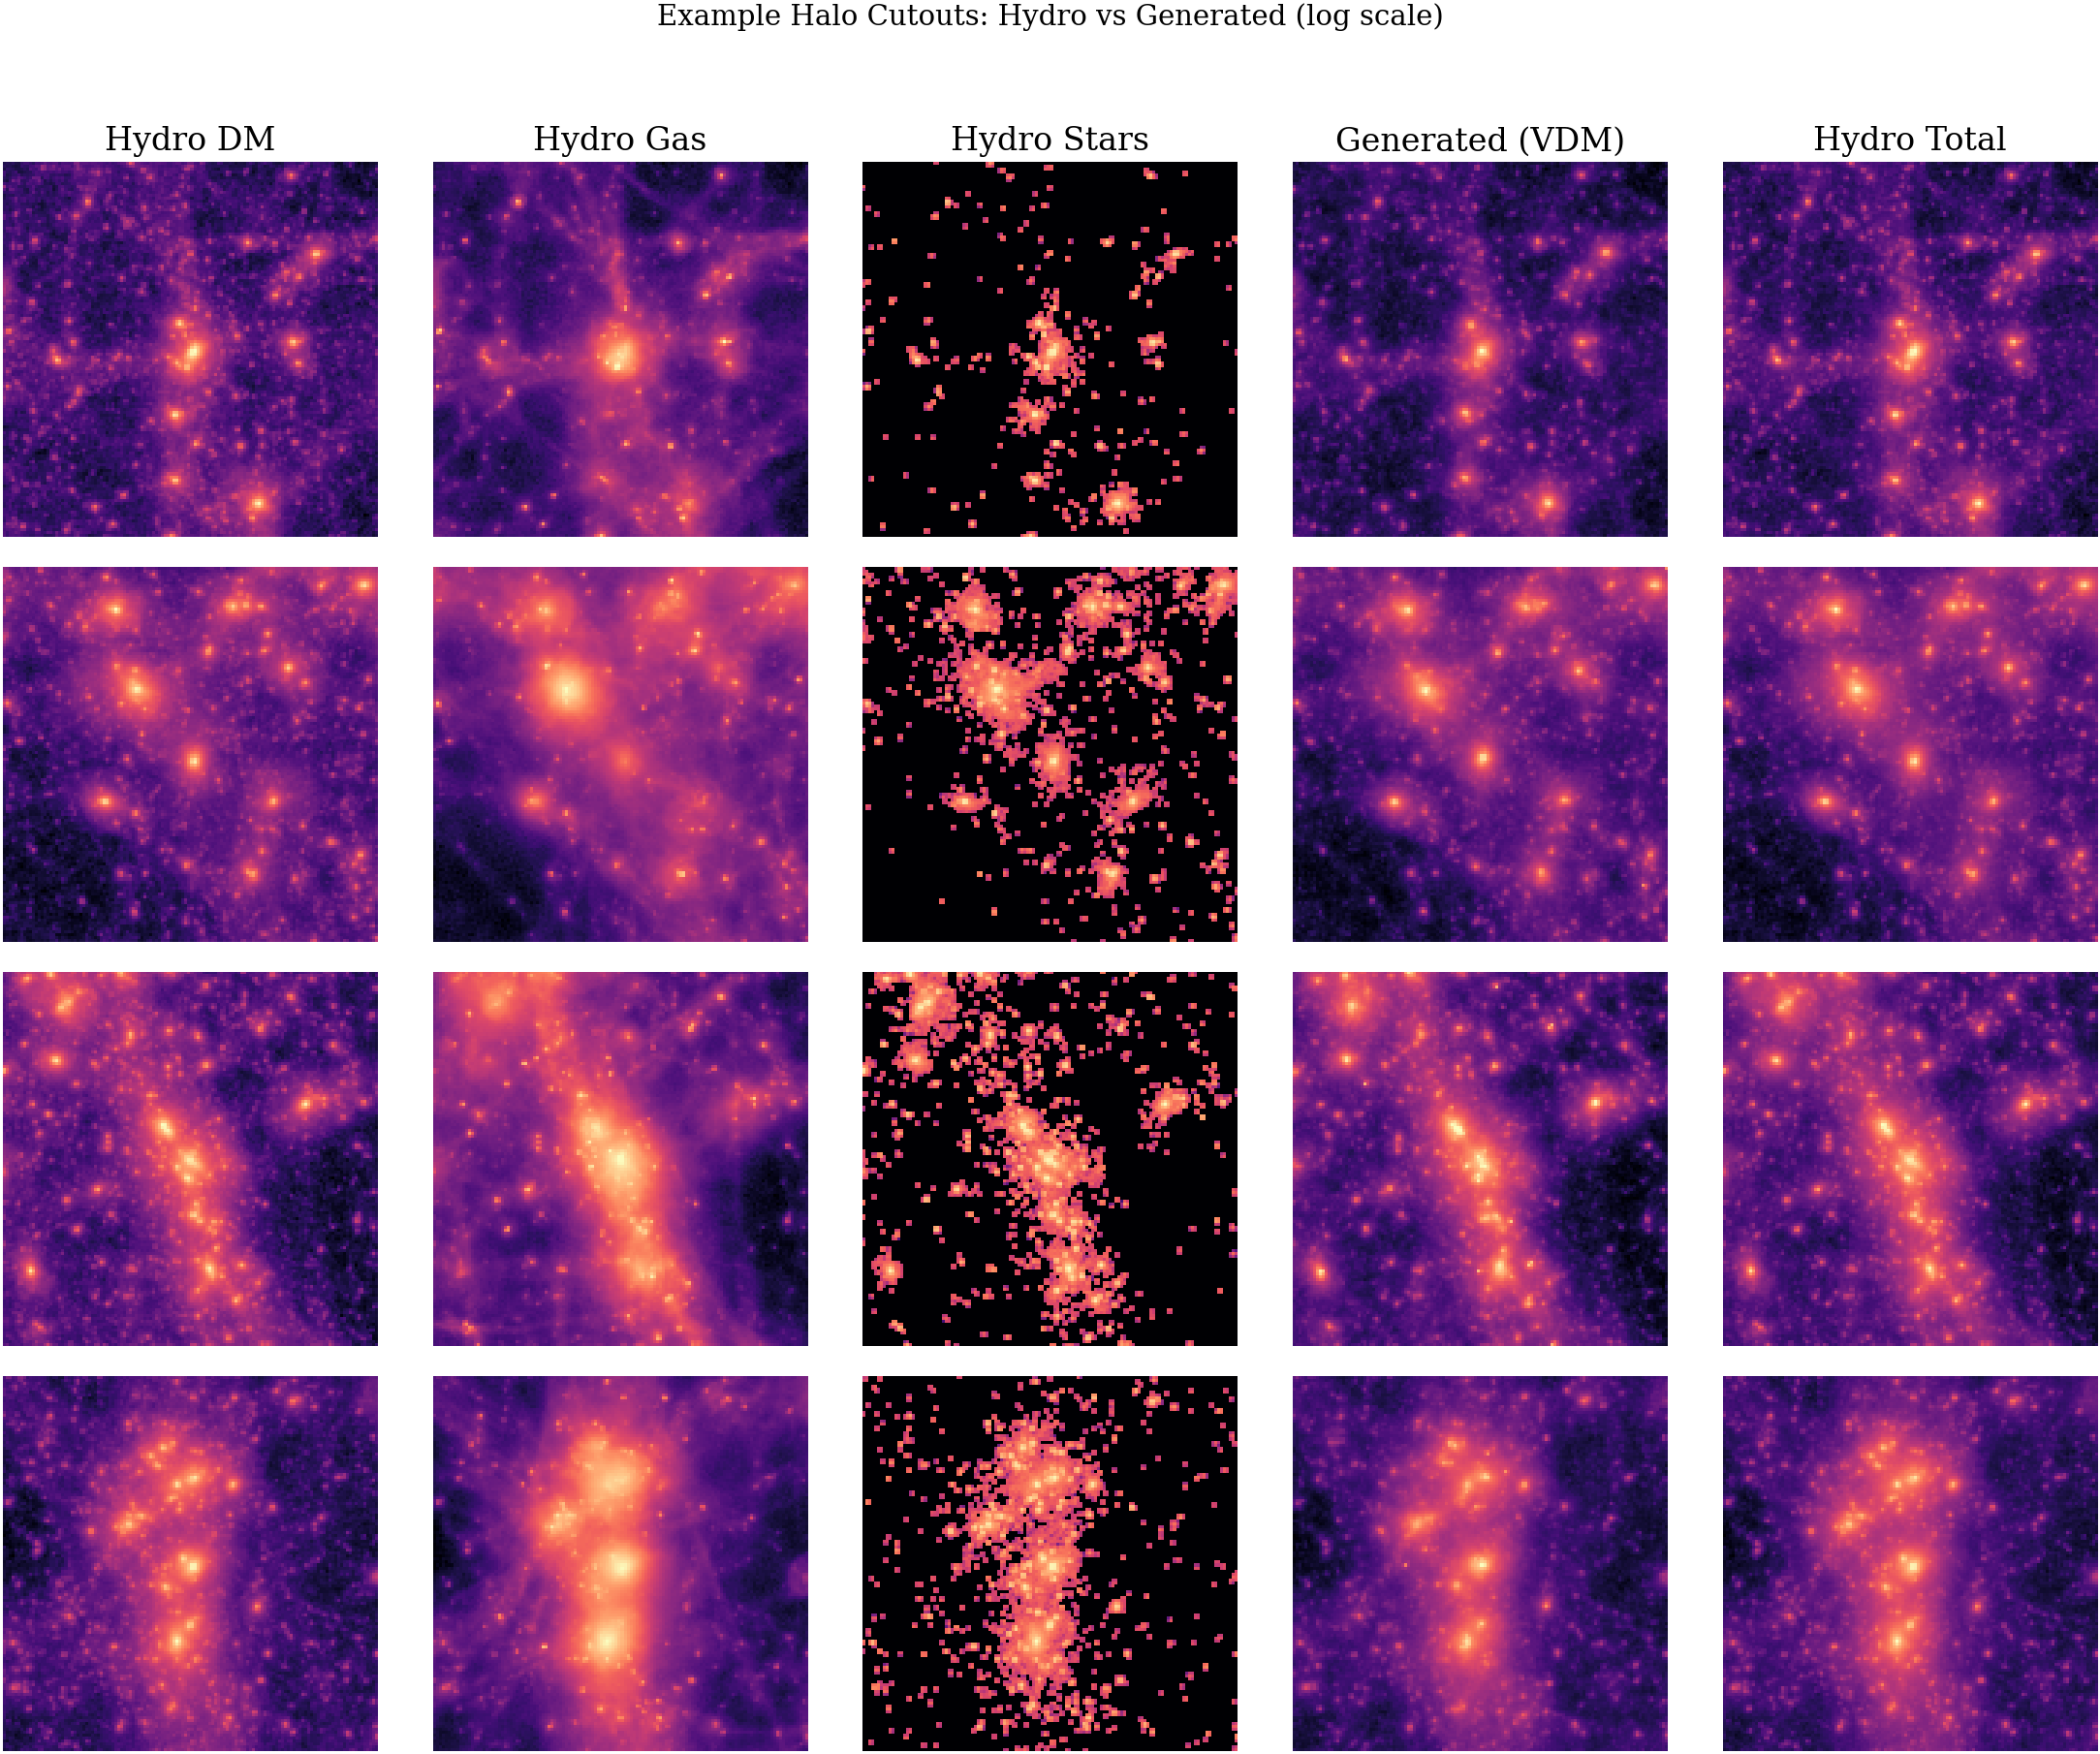

In [24]:
# Visual comparison: Show a few example cutouts side by side
# Pick 4 representative halos (low, mid-low, mid-high, high mass)
n_examples = 4
sorted_indices = np.argsort(halo_masses)
example_indices = [
    sorted_indices[len(sorted_indices)//5],      # ~20th percentile
    sorted_indices[len(sorted_indices)//3],      # ~33rd percentile
    sorted_indices[2*len(sorted_indices)//3],    # ~67th percentile
    sorted_indices[-5]                            # High mass
]

# Pick the first model for visualization
model_name = list(generated_cutouts.keys())[0]
gen_data = generated_cutouts[model_name]['outputs']

fig, axes = plt.subplots(n_examples, 5, figsize=(15, 3*n_examples))

for row, halo_idx in enumerate(example_indices):
    halo_mass = halo_masses[halo_idx]
    
    # Hydro DM
    ax = axes[row, 0]
    im = ax.imshow(np.log10(hydro_cutouts['dm'][halo_idx] + 1), cmap='magma')
    if row == 0:
        ax.set_title('Hydro DM')
    ax.set_ylabel(f'M = {halo_mass:.1e}', fontsize=10)
    ax.axis('off')
    
    # Hydro Gas
    ax = axes[row, 1]
    ax.imshow(np.log10(hydro_cutouts['gas'][halo_idx] + 1), cmap='magma')
    if row == 0:
        ax.set_title('Hydro Gas')
    ax.axis('off')
    
    # Hydro Stars
    ax = axes[row, 2]
    ax.imshow(np.log10(hydro_cutouts['stars'][halo_idx] + 1), cmap='magma')
    if row == 0:
        ax.set_title('Hydro Stars')
    ax.axis('off')
    
    # Generated (resize to match hydro for visualization)
    if gen_data.ndim == 4:
        gen_total = gen_data[halo_idx].sum(axis=0)  # Sum channels
    else:
        gen_total = gen_data[halo_idx]
    
    # Resize generated to hydro size for fair comparison
    H_hydro = hydro_cutouts['dm'].shape[1]
    if gen_total.shape[0] != H_hydro:
        gen_tensor = torch.tensor(gen_total, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        gen_resized = F.interpolate(gen_tensor, size=(H_hydro, H_hydro), mode='bilinear', align_corners=False)
        gen_total = gen_resized.squeeze().numpy()
    
    ax = axes[row, 3]
    ax.imshow(np.log10(gen_total + 1), cmap='magma')
    if row == 0:
        ax.set_title(f'Generated ({model_name})')
    ax.axis('off')
    
    # Hydro Total for comparison
    ax = axes[row, 4]
    ax.imshow(np.log10(hydro_cutouts['total'][halo_idx] + 1), cmap='magma')
    if row == 0:
        ax.set_title('Hydro Total')
    ax.axis('off')

plt.suptitle('Example Halo Cutouts: Hydro vs Generated (log scale)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURE_DIR / 'halo_cutout_examples.png', dpi=150, bbox_inches='tight')
plt.show()